In [1]:
#import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import unicodedata
import os
import warnings
from pandas_profiling import ProfileReport
from helperFunctions import *

#hide warnings
warnings.filterwarnings('ignore')

In [2]:
#determine if we are going to produce a profile report
produceProfileReport = 'N'

In [3]:
#get local directory
filePath = os.path.join('../', '../', '../', 'Data', 'Preprocessing',
                        'NoShowAppointments_Kaggle_May2016.csv')
appt_data = pd.read_csv(filePath,
                        parse_dates=['ScheduledDay', 'AppointmentDay'])

In [4]:
#explore data
appt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns, UTC]
AppointmentDay    110527 non-null datetime64[ns, UTC]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: datetime64[ns, UTC](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


In [5]:
#review data information for each numeric column
appt_data.describe()  

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [6]:
#change column name
appt_data.rename(columns={
    "Hipertension": "Hypertension",
    "SMS_received": "SMSReceived",
    "No-show": "NoShow",
    "Neighbourhood": "Neighborhood",
    "Handcap": "Handicap"
},
                 inplace=True)
appt_data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [7]:
#reorder column names (put feature first)
appt_data = appt_data[[
    'NoShow', 'PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
    'AppointmentDay', 'Age', 'Neighborhood', 'Scholarship', 'Hypertension','Diabetes',
    'Alcoholism', 'Handicap', 'SMSReceived'
]]

In [8]:
#show handicap counts
appt_data['Handicap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handicap, dtype: int64

In [9]:
#change all handicap values greater than 1 to 1
appt_data['Handicap'].replace(2,1,inplace=True)
appt_data['Handicap'].replace(3,1,inplace=True)
appt_data['Handicap'].replace(4,1,inplace=True)

In [10]:
#show handicap counts
appt_data['Handicap'].value_counts()

0    108286
1      2241
Name: Handicap, dtype: int64

In [11]:
# Get patients less than an age of zero
indexNames = appt_data[ appt_data['Age'] < 0 ].index
# Delete these row indexes from dataFrame
appt_data.drop(indexNames , inplace=True)

In [12]:
# cut age groups into categories
category = pd.cut(appt_data.Age,
                  bins=[0, 2, 17, 65, appt_data.Age.max()],
                  labels=['Toddler/baby', 'Child', 'Adult', 'Elderly'])
appt_data.insert(5, 'Age Group', category)

In [13]:
#show age group value counts
appt_data['Age Group'].value_counts()

Adult           69846
Child           19949
Elderly         13301
Toddler/baby     3891
Name: Age Group, dtype: int64

In [14]:
#show patientid
appt_data['PatientId'].head()

0    2.987250e+13
1    5.589978e+14
2    4.262962e+12
3    8.679512e+11
4    8.841186e+12
Name: PatientId, dtype: float64

In [15]:
#explore missing values for object data types
appt_data.select_dtypes(include='object').isnull().sum()

NoShow          0
Gender          0
Neighborhood    0
dtype: int64

In [16]:
#set NoShow to a number value
appt_data['NoShow'].replace('No',0,inplace=True)
appt_data['NoShow'].replace('Yes',1,inplace=True)

#explore missing values for object data types
appt_data.select_dtypes(include='number').isnull().sum()

NoShow           0
PatientId        0
AppointmentID    0
Age              0
Scholarship      0
Hypertension     0
Diabetes         0
Alcoholism       0
Handicap         0
SMSReceived      0
dtype: int64

In [17]:
#look at gender counts
appt_data['Gender'].value_counts()

F    71839
M    38687
Name: Gender, dtype: int64

In [18]:
#show age value counts
appt_data['Age'].value_counts()

0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
98        6
115       5
100       4
102       2
99        1
Name: Age, Length: 103, dtype: int64

In [19]:
#show neighborhood counts
appt_data['Neighborhood'].value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighborhood, Length: 81, dtype: int64

In [20]:
# population a new column for the scheduled time of the day
appt_data['Neighborhood'] = appt_data.apply(
    lambda x: remove_neighborhood_accent(x['Neighborhood']), axis=1)

In [21]:
# show neighborhood counts
appt_data['Neighborhood'].value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTENCIA                    4431
JARDIM DA PENHA                3877
ITARARE                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEANICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighborhood, Length: 81, dtype: int64

In [22]:
#get unique Neighborhood values
len(appt_data['Neighborhood'].unique())

81

In [23]:
# making boolean series for a team name 
no_show = appt_data['NoShow']==1

# group data by no show 
appt_data[no_show].groupby('PatientId').sum()[['NoShow']]


,NoShow
PatientId,
5.628261e+06,1
6.485121e+07,1
8.799645e+07,1
1.224513e+08,2
1.421333e+08,1
...,...
9.988130e+14,1
9.994717e+14,1
9.994792e+14,2


In [25]:
# run same_day_appt function against ScheduledDay and AppointmentDay
appt_data['SameDayAppointment'] = appt_data.apply(
    lambda x: same_day_appt(x['ScheduledDay'], x['AppointmentDay']), axis=1)

# run another apply statement to determine the day of the week
appt_data['AppointmentDayOfWeek'] = appt_data.apply(
    lambda x: appt_day_name(x['AppointmentDay']), axis=1)

# population a new column for the scheduled time of the day
appt_data['ScheduledTimeOfDay'] = appt_data.apply(
    lambda x: scheduled_time_of_day(x['ScheduledDay']), axis=1)

In [26]:
# view Same Day Appointment Data
appt_data['ScheduledTimeOfDay'].head(10)

0      Evening
1      Evening
2      Evening
3      Evening
4      Evening
5      Morning
6    Afternoon
7    Afternoon
8      Morning
9    Afternoon
Name: ScheduledTimeOfDay, dtype: object

In [27]:
# see scheduled time of day
appt_data['ScheduledTimeOfDay'].value_counts()

Morning      68480
Afternoon    31664
Evening      10382
Name: ScheduledTimeOfDay, dtype: int64

In [28]:
# add weather data to appointments
# notice the last two columns 
add_weather_data(appt_data)

,NoShow,PatientId,AppointmentID,Gender,ScheduledDay,Age Group,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,SameDayAppointment,AppointmentDayOfWeek,ScheduledTimeOfDay,RainClassification,NormalVersusActualTempAverage
0,0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,Adult,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,1,Friday,Evening,1,below
1,0,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,Adult,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,1,Friday,Evening,1,below
2,0,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,Adult,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,1,Friday,Evening,1,below
3,0,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,Child,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,Friday,Evening,1,below
4,0,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,Adult,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,1,Friday,Evening,1,below
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,0,2.572134e+12,5651768,F,2016-05-03 09:15:35+00:00,Adult,2016-06-07 00:00:00+00:00,56,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday,Morning,1,above
110523,0,3.596266e+12,5650093,F,2016-05-03 07:27:33+00:00,Adult,2016-06-07 00:00:00+00:00,51,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday,Morning,1,above
110524,0,1.557663e+13,5630692,F,2016-04-27 16:03:52+00:00,Adult,2016-06-07 00:00:00+00:00,21,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday,Evening,1,above
110525,0,9.213493e+13,5630323,F,2016-04-27 15:09:23+00:00,Adult,2016-06-07 00:00:00+00:00,38,MARIA ORTIZ,0,0,0,0,0,1,0,Tuesday,Afternoon,1,above


In [29]:
#show the counts by rain classification
#rainclassification = 1 is no rain, anything higher than 1 means rain
appt_data['RainClassification'].value_counts()

1    93555
2    12577
3     4394
Name: RainClassification, dtype: int64

In [30]:
#show the counts by normal versus actual temp average
appt_data['NormalVersusActualTempAverage'].value_counts()

above    53051
same     29238
below    28237
Name: NormalVersusActualTempAverage, dtype: int64

In [31]:
#drop columns with co-linearity 
appt_data.drop(['ScheduledDay','AppointmentDay','Age'],axis=1,inplace=True)

In [32]:
pd.options.display.max_rows = 999
data = appt_data['Neighborhood'].value_counts()
data.sort_values(ascending=False)


JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTENCIA                    4431
JARDIM DA PENHA                3877
ITARARE                        3514
CENTRO                         3334
TABUAZEIRO                     3132
SANTA MARTHA                   3131
JESUS DE NAZARETH              2853
BONFIM                         2773
SANTO ANTONIO                  2746
SANTO ANDRE                    2571
CARATOIRA                      2565
JABOUR                         2509
SAO PEDRO                      2448
ILHA DO PRINCIPE               2266
NOVA PALESTINA                 2264
ANDORINHAS                     2262
DA PENHA                       2217
ROMAO                          2214
GURIGICA                       2018
SAO JOSE                       1977
BELA VISTA                     1907
MARUIPE                        1902
FORTE SAO JOAO                 1889
ILHA DE SANTA MARIA            1885
SAO CRISTOVAO                  1836
REDENCAO                    

In [33]:
#set max display back to default (15)
pd.options.display.max_rows = 15

In [34]:
#create profile before one hot encoding data
if produceProfileReport == 'Y':
    profile = ProfileReport(appt_data, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [35]:
#add profile to file
if produceProfileReport == 'Y':
    profile.to_file(output_file=os.path.join('../','../','../','Visualizations','Appt_Data_Report.html'))

In [36]:
if produceProfileReport == 'Y':
    profile.to_notebook_iframe()

In [37]:
#create dummy classifications (e.g. one hot encoding)
#columns with classification values will get multiple columns created
appt_data = pd.get_dummies(appt_data)

In [38]:
appt_data.columns.to_list()

['NoShow',
 'PatientId',
 'AppointmentID',
 'Scholarship',
 'Hypertension',
 'Diabetes',
 'Alcoholism',
 'Handicap',
 'SMSReceived',
 'SameDayAppointment',
 'Gender_F',
 'Gender_M',
 'Age Group_Toddler/baby',
 'Age Group_Child',
 'Age Group_Adult',
 'Age Group_Elderly',
 'Neighborhood_AEROPORTO',
 'Neighborhood_ANDORINHAS',
 'Neighborhood_ANTONIO HONORIO',
 'Neighborhood_ARIOVALDO FAVALESSA',
 'Neighborhood_BARRO VERMELHO',
 'Neighborhood_BELA VISTA',
 'Neighborhood_BENTO FERREIRA',
 'Neighborhood_BOA VISTA',
 'Neighborhood_BONFIM',
 'Neighborhood_CARATOIRA',
 'Neighborhood_CENTRO',
 'Neighborhood_COMDUSA',
 'Neighborhood_CONQUISTA',
 'Neighborhood_CONSOLACAO',
 'Neighborhood_CRUZAMENTO',
 'Neighborhood_DA PENHA',
 'Neighborhood_DE LOURDES',
 'Neighborhood_DO CABRAL',
 'Neighborhood_DO MOSCOSO',
 'Neighborhood_DO QUADRO',
 'Neighborhood_ENSEADA DO SUA',
 'Neighborhood_ESTRELINHA',
 'Neighborhood_FONTE GRANDE',
 'Neighborhood_FORTE SAO JOAO',
 'Neighborhood_FRADINHOS',
 'Neighborhood_GO

In [39]:
#show no show count by patient itd
appt_data['NoShowSum'] = appt_data.groupby('PatientId')['NoShow'].transform('sum')

In [40]:
#see those with no show sum over 1
appt_data['NoShowSum'].value_counts()

0     67482
1     28508
2      8984
3      2923
4      1215
      ...  
15       20
18       18
16       16
14       14
13       13
Name: NoShowSum, Length: 18, dtype: int64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


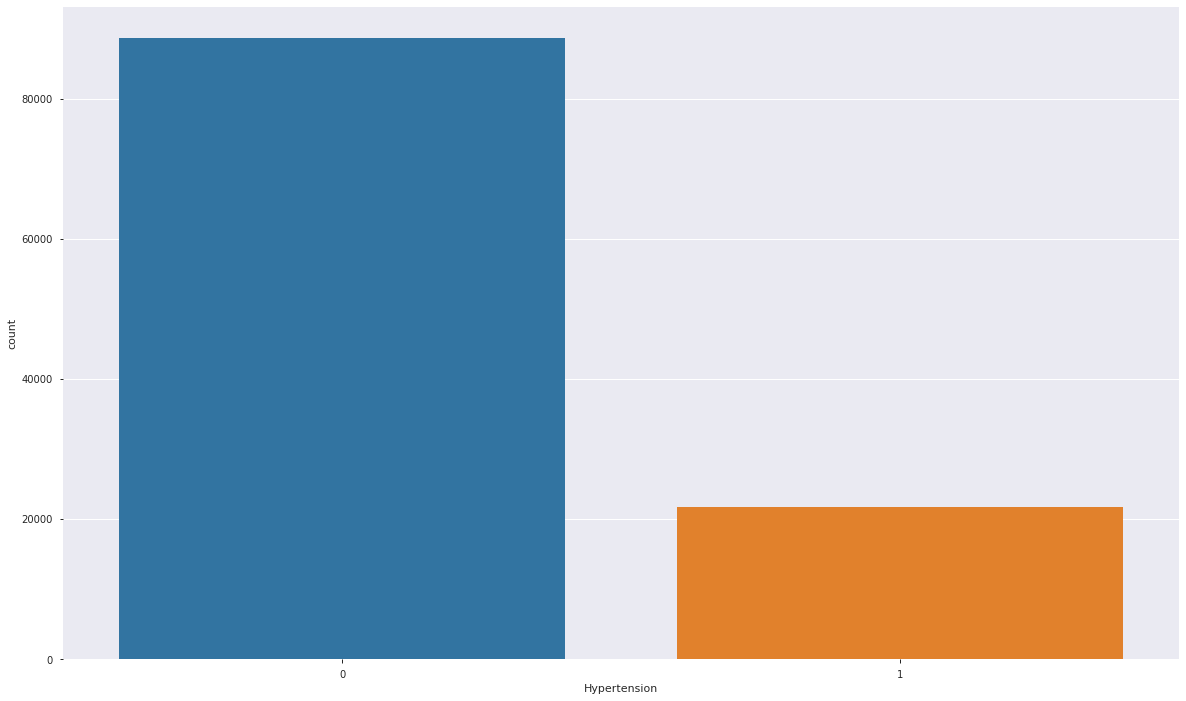

In [41]:
plt.figure(figsize=(20,12))
col = 'Hypertension'
sns.countplot(appt_data[col])
plt.savefig(os.path.join('../','../','../','Visualizations',f"{col}_Count.png"))

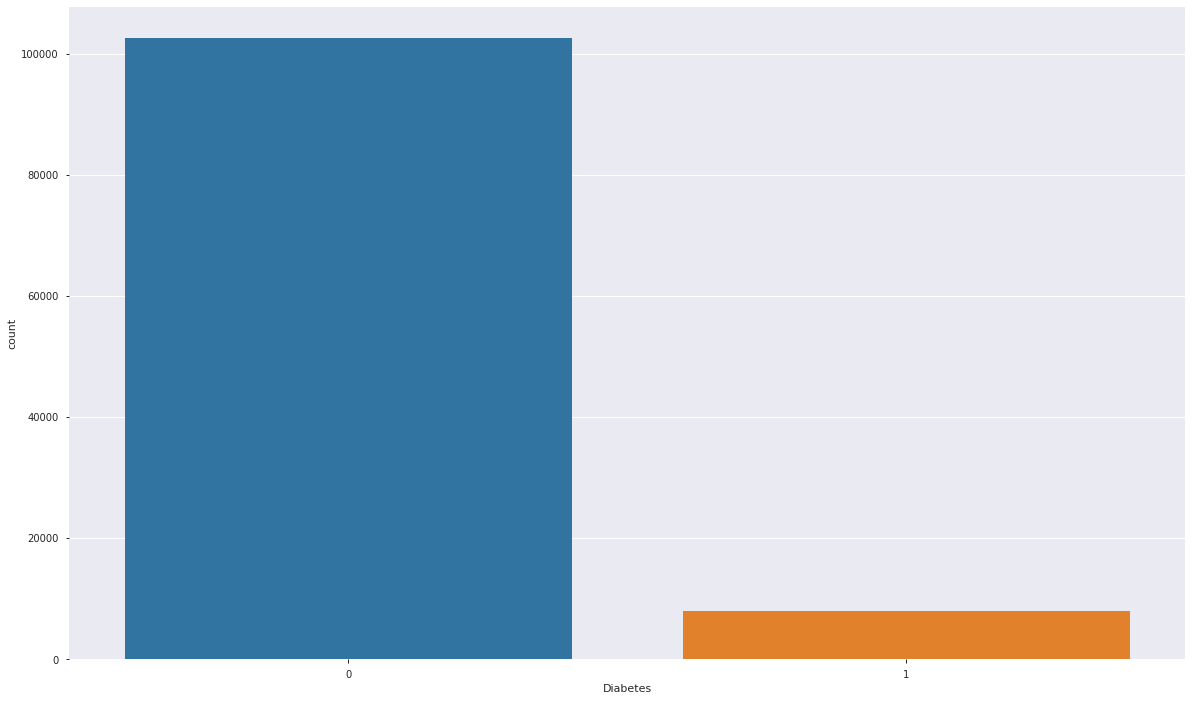

In [42]:
plt.figure(figsize=(20,12))
col = 'Diabetes'
sns.countplot(appt_data[col])
plt.savefig(os.path.join('../','../','../','Visualizations',f"{col}_Count.png"))

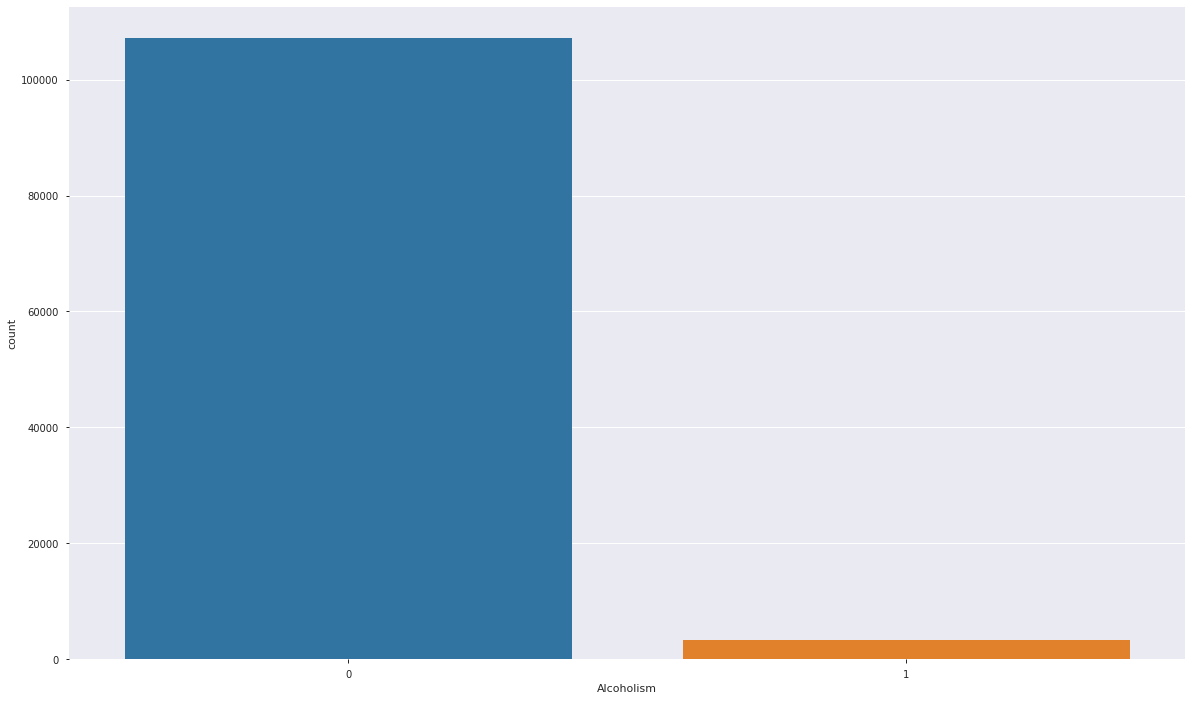

In [43]:
plt.figure(figsize=(20,12))
col = 'Alcoholism'
sns.countplot(appt_data[col])
plt.savefig(os.path.join('../','../','../','Visualizations',f"{col}_Count.png"))

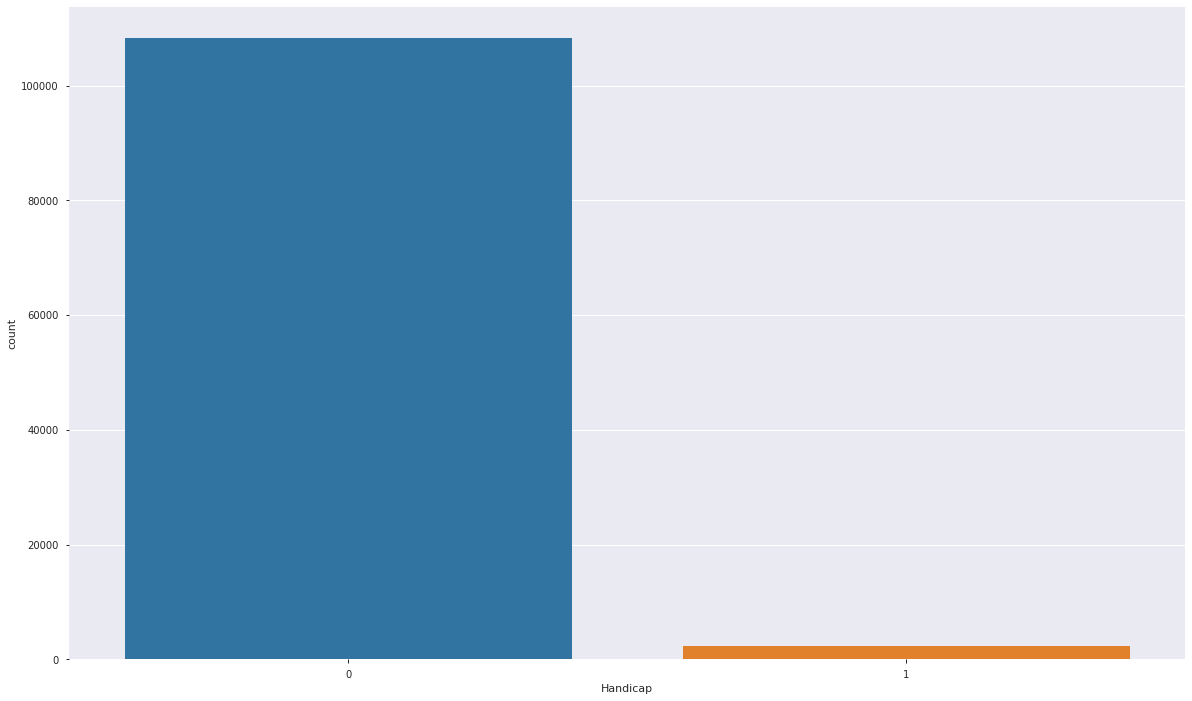

In [44]:
plt.figure(figsize=(20,12))
col = 'Handicap'
sns.countplot(appt_data[col])
plt.savefig(os.path.join('../','../','../','Visualizations',f"{col}_Count.png"))


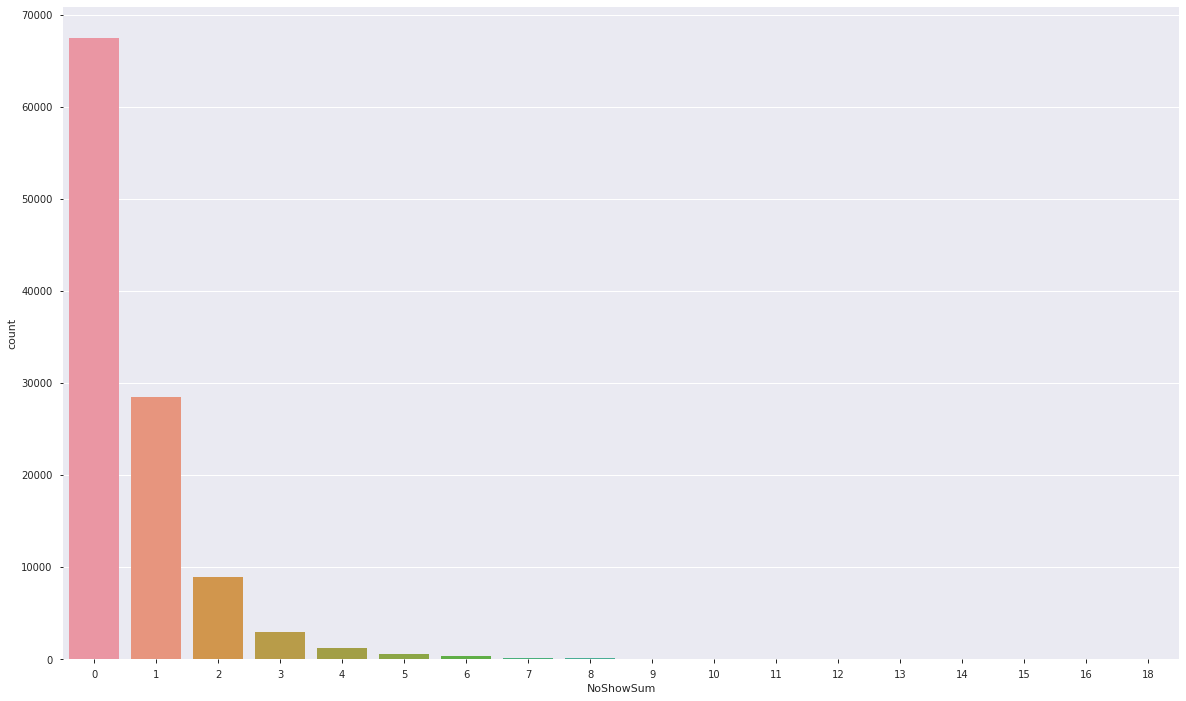

In [45]:
plt.figure(figsize=(20,12))
col = 'NoShowSum'
sns.countplot(appt_data[col])
plt.savefig(os.path.join('../','../','../','Visualizations',f"{col}_Count.png"))

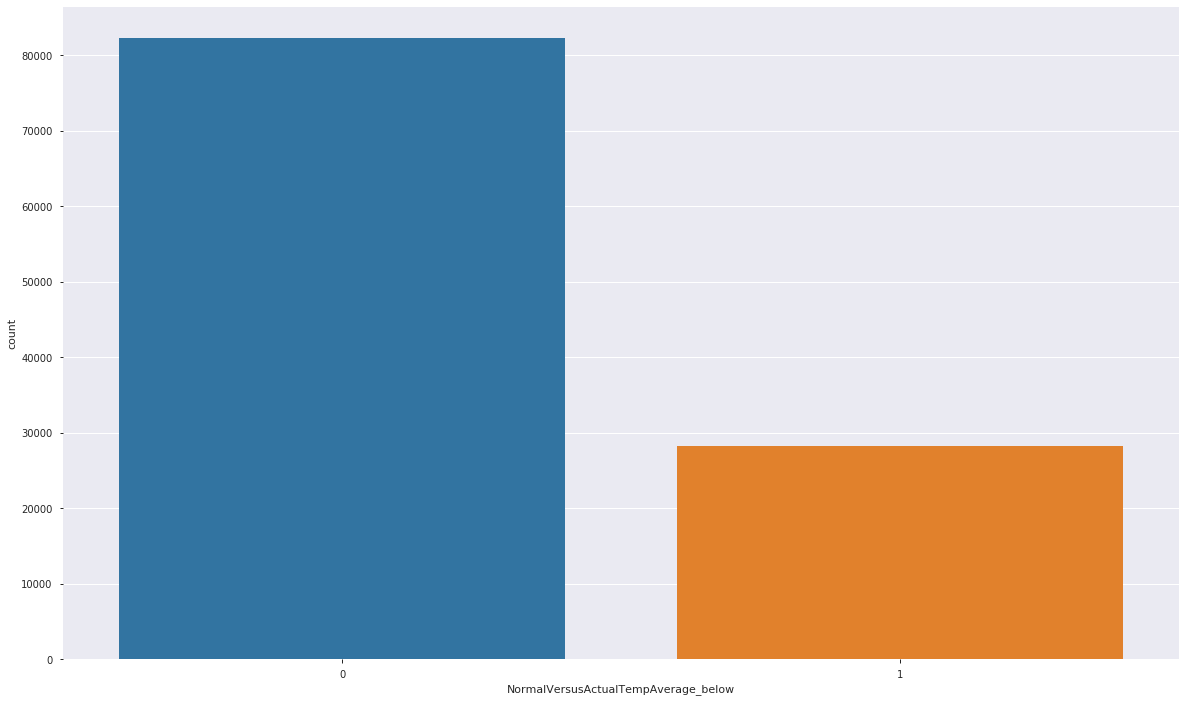

In [46]:
plt.figure(figsize=(20,12))
col = 'NormalVersusActualTempAverage_below'
sns.countplot(appt_data[col])
plt.savefig(os.path.join('../','../','../','Visualizations',f"{col}_Count.png"))

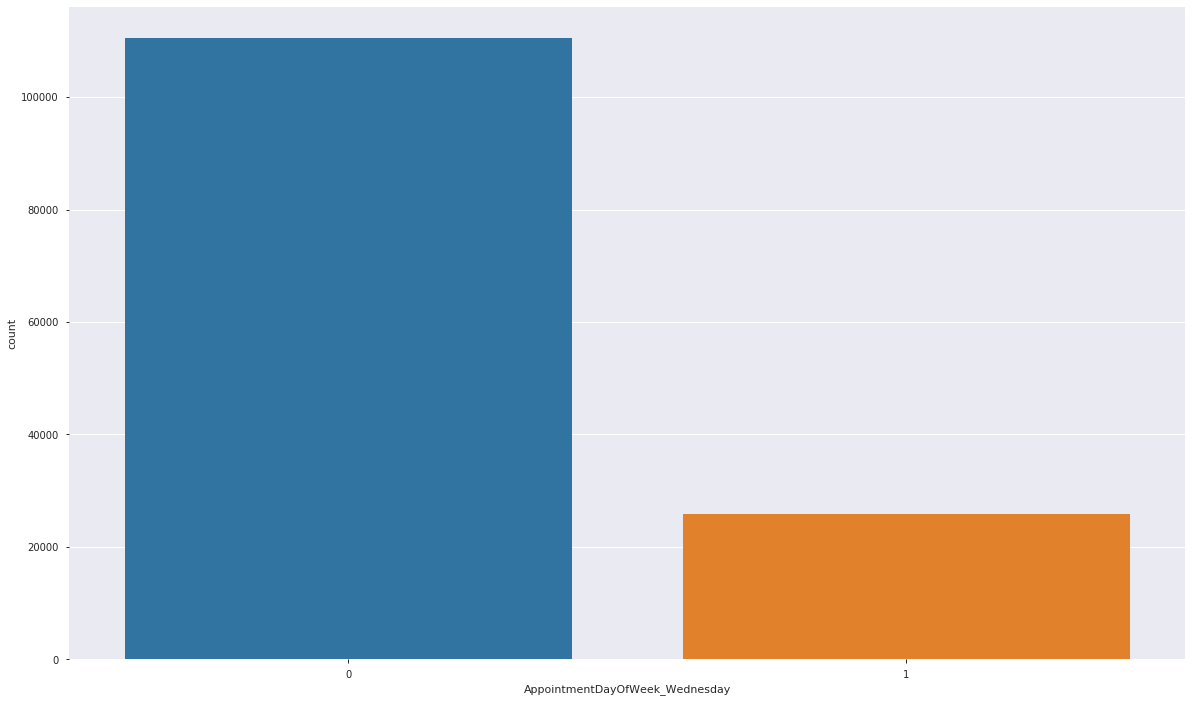

In [47]:
plt.figure(figsize=(20,12))
cols = [ a for a in appt_data.columns.to_list() if 'AppointmentDayOf' in a ]

for c in cols:
    sns.countplot(appt_data[c])
    plt.savefig(os.path.join('../','../','../','Visualizations',f"{c}_Count.png"))

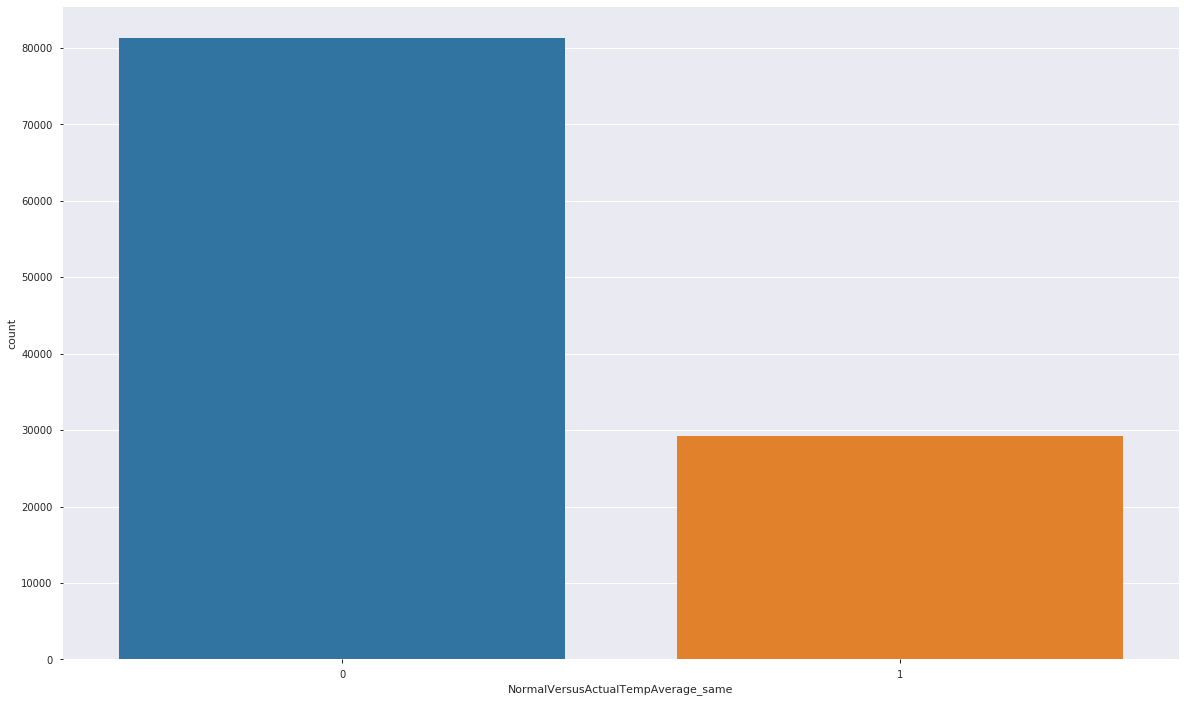

In [48]:
plt.figure(figsize=(20,12))
col = 'NormalVersusActualTempAverage_same'
sns.countplot(appt_data[col])
plt.savefig(os.path.join('../','../','../','Visualizations',f"{col}_Count.png"))

In [49]:
#add cleaned appointment data to stage folder
filePath = os.path.join('../','../','../','Data','Stage','NoShowAppointments_cleaned.csv')
appt_data.to_csv(filePath,index=False)

In [50]:
#remove data from memory
del appt_data